This notebook performs the model souping recipes as introduced in [Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time](https://arxiv.org/abs/2203.05482). Specifically, we implement the uniform model soup and the greedy model soup. 

## Initial setup

In [1]:
!pip install datasets transformers -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")m

## Load dataset

In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Preprocessing the dataset

In [4]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


emotions_encoded = emotions.map(tokenize, batched=True)
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Utilities to compute accuracy for a given dataset split

In [6]:
def get_test_accuracy(model):
    def fn(batch):
        inputs = {
            k: v.to(device)
            for k, v in batch.items()
            if k in tokenizer.model_input_names
        }
        with torch.no_grad():
            output = model(**inputs)
            pred_label = torch.argmax(output.logits, axis=-1)
        return {"predicted_label": pred_label.cpu().numpy()}

    return fn


def compute_test_accuracy(model, split="validation"):
    accuracy_fn = get_test_accuracy(model)

    new_dataset = emotions_encoded[split].map(accuracy_fn, batched=True, batch_size=128)
    new_dataset.set_format("pandas")

    cols = ["label", "predicted_label"]
    df = new_dataset[:][cols]
    return sum(df["label"] == df["predicted_label"]) / len(df)

## Obtain accuracies for all the fine-tuned checkpoints on the validation split

In [7]:
from transformers import AutoModelForSequenceClassification

validation_accuracies = {}

lrs = [3e-5, 2e-5, 6e-4, 1e-5, 3e-4]
wds = [1e-2, 1e-3, 3e-3, 2e-3, 3e-2]

for lr, wd in zip(lrs, wds):
    model_name = f"{model_ckpt}-finetuned-emotion-lr-{lr}-wd-{str(wd).replace('.', '')}"
    model_id = f"sayakpaul/{model_name}"
    print(f"Loading checkpoint: {model_id}.")
    model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
    print("Checkpoint loaded.")

    accuracy = compute_test_accuracy(model, split="validation")
    validation_accuracies.update({model_name: accuracy})

Loading checkpoint: sayakpaul/distilbert-base-uncased-finetuned-emotion-lr-3e-05-wd-001.


Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Checkpoint loaded.


  0%|          | 0/16 [00:00<?, ?ba/s]

AttributeError: 'list' object has no attribute 'to'

Surprisingly, the `test` split doesn't run into this error. I have created an [issue thread](https://github.com/huggingface/datasets/issues/5179). 

In [8]:
validation_accuracies = dict(
    sorted(validation_accuracies.items(), key=lambda item: item[1], reverse=True)
)
validation_accuracies

{'distilbert-base-uncased-finetuned-emotion-lr-0.0003-wd-003': 0.928,
 'distilbert-base-uncased-finetuned-emotion-lr-3e-05-wd-001': 0.9125,
 'distilbert-base-uncased-finetuned-emotion-lr-2e-05-wd-0001': 0.893,
 'distilbert-base-uncased-finetuned-emotion-lr-0.0006-wd-0003': 0.8925,
 'distilbert-base-uncased-finetuned-emotion-lr-1e-05-wd-0002': 0.7725}

Now, plot the accuracy scores (plotting code taken from [this Colab Notebook by Cade Gordon](https://colab.research.google.com/drive/1UmK-phTRXC4HoKb7_rScawnRqlG82svF?usp=sharing)).

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Matplotlib is building the font cache; this may take a moment.


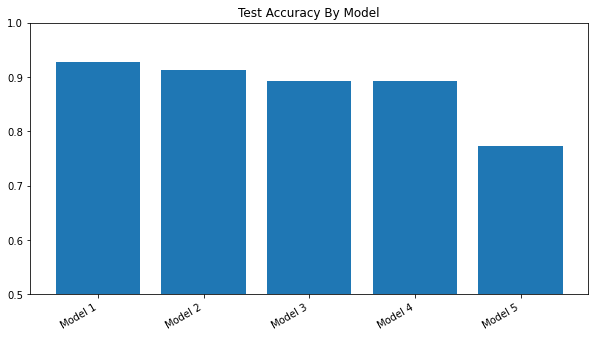

In [9]:
import matplotlib.pyplot as plt

names = [f'Model {i+1}' for i in range(len(validation_accuracies))]

plt.figure(figsize = (10, 5))
plt.bar(names, list(validation_accuracies.values()))
plt.title("Test Accuracy By Model")
plt.ylim([0.5, 1])
plt.xticks(rotation=30, ha='right')

plt.show()

## Souping utility

In [10]:
def get_souped_model(state_dicts):
    new_state_dict = {}
    state_dict_keys = list(state_dicts[0].keys())

    for k in state_dict_keys:
        temp_weights = []
        for state_dict in state_dicts:
            temp_weights.append(state_dict[k].cpu())

        stacked_weights = torch.stack(temp_weights)
        averaged_weights = torch.mean(stacked_weights, dim=0)

        new_state_dict.update({k: averaged_weights})

    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6)
    model.load_state_dict(new_state_dict)
    return model.to(device)

In [11]:
all_state_dicts = []

# Recall that `validation_accuracies` keys are sorted in the decreasing order of the
# respective values.
for model_name in validation_accuracies:
    model_id = f"sayakpaul/{model_name}"

    print(f"Loading checkpoint: {model_id}.")
    state_dict = AutoModelForSequenceClassification.from_pretrained(
        model_id
    ).state_dict()
    all_state_dicts.append(state_dict)

Loading checkpoint: sayakpaul/distilbert-base-uncased-finetuned-emotion-lr-0.0003-wd-003.
Loading checkpoint: sayakpaul/distilbert-base-uncased-finetuned-emotion-lr-3e-05-wd-001.
Loading checkpoint: sayakpaul/distilbert-base-uncased-finetuned-emotion-lr-2e-05-wd-0001.
Loading checkpoint: sayakpaul/distilbert-base-uncased-finetuned-emotion-lr-0.0006-wd-0003.
Loading checkpoint: sayakpaul/distilbert-base-uncased-finetuned-emotion-lr-1e-05-wd-0002.


## Uniform soup

Uniform soup is when you average all the available checkpoints. 

In [12]:
uniform_souped_model = get_souped_model(all_state_dicts)

names.append("Uniform Soup")

validation_accuracies.update(
    {"uniform_soup": compute_test_accuracy(uniform_souped_model, "validation")}
)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/16 [00:00<?, ?ba/s]

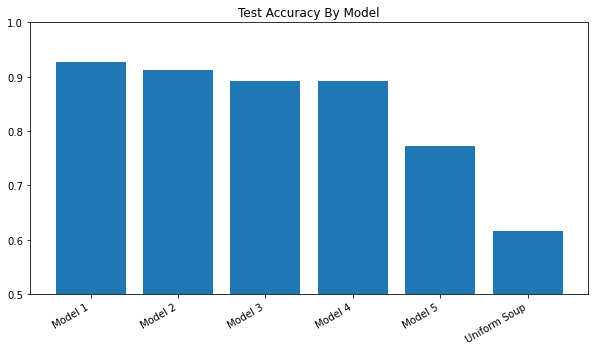

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(names, list(validation_accuracies.values()))
plt.title("Test Accuracy By Model")
plt.ylim([0.5, 1])
plt.xticks(rotation=30, ha="right")

plt.show()

Performance decreased 🤯

## Greedy soup

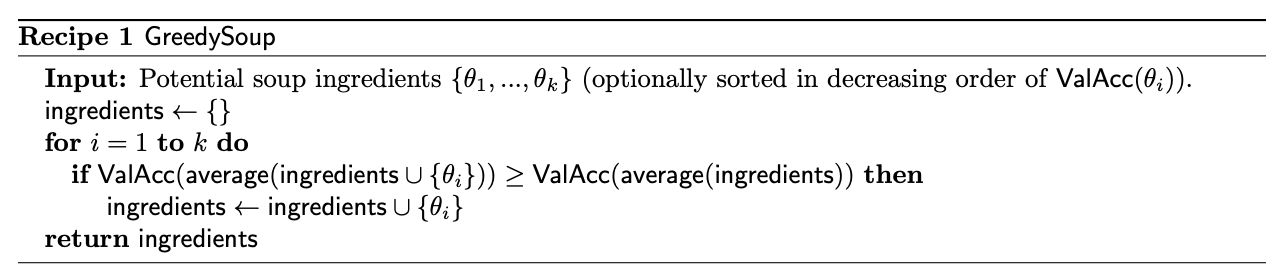

In [21]:
greedy_state_dict = [all_state_dicts[0]]
current_best = list(validation_accuracies.values())[0]
indices = [0]

for i in range(1, len(all_state_dicts)):
    greedy_state_dict.append(all_state_dicts[i])
    souped_model = get_souped_model(greedy_state_dict)
    accuracy = compute_test_accuracy(souped_model, "validation")
    print(f"Accuracy: {accuracy}, current best: {current_best}")

    if accuracy > current_best:
        current_best = accuracy
        indices.append(i)
    else:
        greedy_state_dict = [all_state_dicts[0]]

print(indices, current_best)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/16 [00:00<?, ?ba/s]

Accuracy: 0.924, current best: 0.928


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/16 [00:00<?, ?ba/s]

Accuracy: 0.925, current best: 0.928


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/16 [00:00<?, ?ba/s]

Accuracy: 0.703, current best: 0.928


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

  0%|          | 0/16 [00:00<?, ?ba/s]

Accuracy: 0.918, current best: 0.928
[0] 0.928


Still not there 🤯 Maybe try with a bigger model like BERT-base to see if it works. 